# Практика 2 часть 4. Многоклассовая классификация в `sklearn`: логистическая регрессия, метрики и полиномиальные признаки

В этом ноутбуке мы разберём, как решать задачу **многоклассовой классификации** с помощью библиотеки `scikit-learn`:

1. Сгенерируем синтетический двумерный датасет с тремя классами.
2. Разделим данные на train / test.
3. Построим пайплайн:
   - стандартизация признаков,
   - `LogisticRegression` с многоклассовой логистической регрессией (softmax).
4. Рассчитаем и подробно разберём **метрики качества** многоклассовой классификации:
   - `accuracy`,
   - confusion matrix,
   - `precision`, `recall`, `F1` (macro / micro / weighted),
   - интерпретацию `classification_report`.
5. Визуализируем:
   - решающие области (decision regions),
   - confusion matrix,
   - распределение вероятностей по классам для отдельных объектов.
6. Добавим **полиномиальные признаки** (через `PolynomialFeatures`), обучим модель и сравним:
   - как меняется форма решающих границ,
   - как меняются метрики на train / test,
   - появление потенциального переобучения.


In [1]:
# Импорт необходимых библиотек

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score
)

# Настройки визуализации
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['font.size'] = 12

# Фиксируем сид для воспроизводимости
np.random.seed(42)

## 1. Синтетический датасет для трёх классов

Мы сгенерируем двумерные данные $(x_1, x_2)$ для трёх классов в виде трёх гауссовских облаков:

- класс 0,
- класс 1,
- класс 2.

Такая конструкция удобна, потому что:

- данные можно легко визуализировать на плоскости,
- границы между классами примерно линейные, но их можно усложнить полиномиальными признаками,
- поведение модели и метрик хорошо интерпретируется визуально.


Форма X: (600, 2)
Форма y: (600,)
Классы и их количество: (array([0, 1, 2]), array([200, 200, 200]))


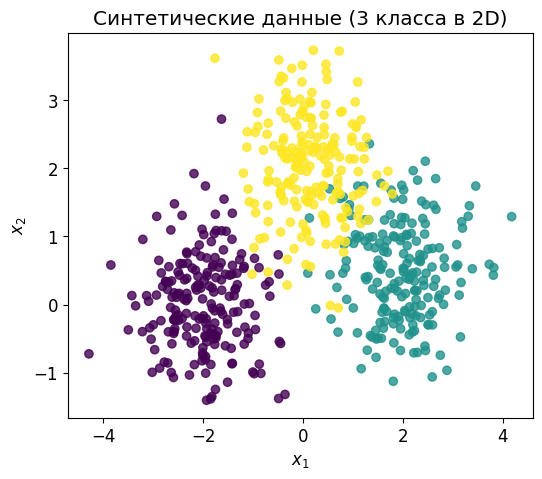

In [2]:
# Генерация синтетических данных (3 класса в 2D)

n_samples_per_class = 200

# Класс 0
mean0 = [-2.0, 0.0]
cov0 = [[0.5, 0.0],
        [0.0, 0.5]]
X0 = np.random.multivariate_normal(mean0, cov0, size=n_samples_per_class)
y0 = np.zeros(n_samples_per_class, dtype=int)

# Класс 1
mean1 = [2.0, 0.5]
cov1 = [[0.5, 0.0],
        [0.0, 0.5]]
X1 = np.random.multivariate_normal(mean1, cov1, size=n_samples_per_class)
y1 = np.ones(n_samples_per_class, dtype=int)

# Класс 2
mean2 = [0.0, 2.0]
cov2 = [[0.5, 0.0],
        [0.0, 0.5]]
X2 = np.random.multivariate_normal(mean2, cov2, size=n_samples_per_class)
y2 = np.full(n_samples_per_class, 2, dtype=int)

# Объединяем
X = np.vstack([X0, X1, X2])   # (n_samples, 2)
y = np.concatenate([y0, y1, y2])

print("Форма X:", X.shape)
print("Форма y:", y.shape)
print("Классы и их количество:", np.unique(y, return_counts=True))

# Визуализируем данные
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", alpha=0.8)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Синтетические данные (3 класса в 2D)")
plt.show()

### 1.1. Разбиение на обучающую и тестовую выборки

Стандартный шаг в ML-пайплайне — разделить данные на:

- обучающую выборку (**train**) — на ней подбираем параметры модели,
- тестовую выборку (**test**) — на ней оцениваем обобщающую способность модели.

Используем `train_test_split` из `sklearn`.


In [3]:
# Разделение на train и test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (420, 2) (420,)
Test shape: (180, 2) (180,)


## 2. Многоклассовая логистическая регрессия в `sklearn`

В `sklearn` класс `LogisticRegression` поддерживает многоклассовый режим двумя основными способами:

1. **OvR (One-vs-Rest)** — по одному бинарному классификатору на класс:
   - `multi_class="ovr"`,
   - каждая модель решает задачу «класс $k$ против всех остальных».

2. **Multinomial (softmax-регрессия)** — **единая** многоклассовая модель:
   - `multi_class="multinomial"`,
   - используется softmax над логитами всех классов,
   - это ближе всего к той теории, которую мы выводили для softmax-регрессии.

В этом ноутбуке мы сосредоточимся на **multinomial логистической регрессии** как на корректной вероятностной модели для многоклассового случая.

Также важно:

- использовать `solver="lbfgs"` (или `newton-cg`, `saga`) для `multi_class="multinomial"`,
- стандартизовать признаки перед логрегом (в особенности при добавлении полиномиальных признаков).

Мы будем использовать `Pipeline`, чтобы собрать:

1. `StandardScaler` — стандартизация признаков,
2. `LogisticRegression(multi_class="multinomial", solver="lbfgs")`.

\* Использование `multi_class` с sklearn>=1.5 стало deprecated, поэтому по дефолту останется чисто multinomial версия


### 2.1. Пайплайн: стандартизация + логистическая регрессия (multinomial)

In [4]:
# Пайплайн: StandardScaler + многоклассовая логистическая регрессия

logreg_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=500,
        random_state=42
    ))
])

# Обучаем модель
logreg_clf.fit(X_train, y_train)

# Оцениваем accuracy на train и test
y_train_pred = logreg_clf.predict(X_train)
y_test_pred = logreg_clf.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f"Accuracy (train): {acc_train:.4f}")
print(f"Accuracy (test):  {acc_test:.4f}")

Accuracy (train): 0.9524
Accuracy (test):  0.9500


C:\work\PISH\data_analysis_lectures\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### 2.2. Визуализация решающих областей

Построим **decision regions** для обученной модели:

1. Строим сетку точек в пространстве $(x_1, x_2)$.
2. Прогоняем их через пайплайн `logreg_clf`.
3. Для каждой точки смотрим предсказанный класс `predict`.
4. Рисуем фон (области) по предсказанным классам и поверх — реальные точки выборки.

Такое изображение очень хорошо показывает, как модель разделяет пространство признаков.


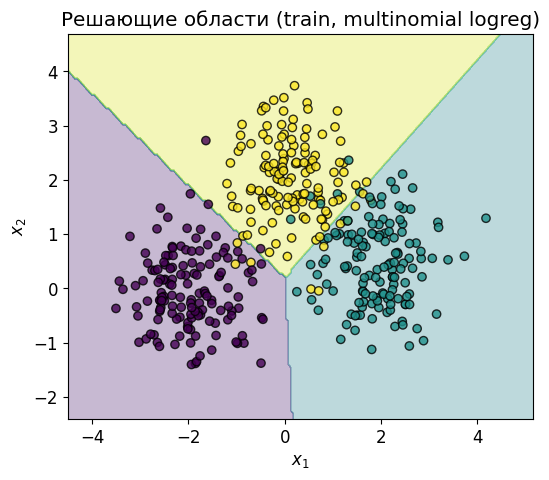

In [5]:
def plot_decision_regions(model, X, y, title=None, grid_step=0.05):
    # Определяем диапазон по осям
    x1_min, x1_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    x2_min, x2_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0

    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, grid_step),
        np.arange(x2_min, x2_max, grid_step)
    )

    grid_points = np.c_[xx1.ravel(), xx2.ravel()]

    # Предсказания модели для всех точек сетки
    y_grid = model.predict(grid_points)
    y_grid = y_grid.reshape(xx1.shape)

    # Рисуем фон + реальные точки
    plt.contourf(xx1, xx2, y_grid, alpha=0.3, cmap="viridis")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", edgecolor="k", alpha=0.8)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    if title is not None:
        plt.title(title)
    plt.show()


plot_decision_regions(logreg_clf, X_train, y_train, title="Решающие области (train, multinomial logreg)")

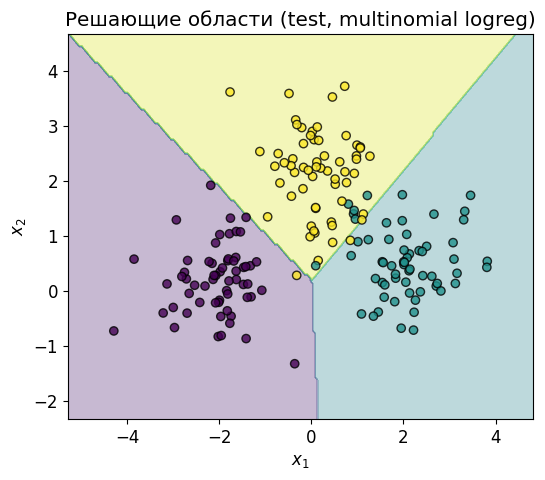

In [6]:
plot_decision_regions(logreg_clf, X_test, y_test, title="Решающие области (test, multinomial logreg)")

## 3. Метрики для многоклассовой классификации

В многоклассовой классификации метрики качества обобщают бинарные понятия **TP / FP / FN / TN** на несколько классов.

Начнём с основных.

### 3.1. Accuracy

**Accuracy** — доля правильно предсказанных объектов:

$$
\text{Accuracy} = \frac{\text{количество верно классифицированных объектов}}{\text{общее количество объектов}}.
$$

Плюсы:

- легко интерпретируется,
- хороша при более-менее сбалансированных классах.

Минусы:

- плохо отражает качество при сильном дисбалансе классов,
- не показывает, какие конкретно классы модель путает.

Поэтому вводятся более тонкие метрики.


### 3.2. Confusion matrix (матрица ошибок)

**Confusion matrix** (матрица ошибок) для многоклассового случая — это матрица размера $K \times K$:

- строки — **истинные классы**,
- столбцы — **предсказанные классы**,
- элемент $(i, j)$ — количество объектов, у которых
  - истинный класс = $i$,
  - предсказанный класс = $j$.

Идеальный случай: вся масса на диагонали.


In [7]:
# Confusion matrix для тестовой выборки

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix (сырой вид):")
print(cm)

Confusion matrix (сырой вид):
[[60  0  0]
 [ 0 54  6]
 [ 1  2 57]]


Визуализируем confusion matrix в виде «тепловой карты», чтобы наглядно увидеть, какие классы путаются между собой чаще всего.


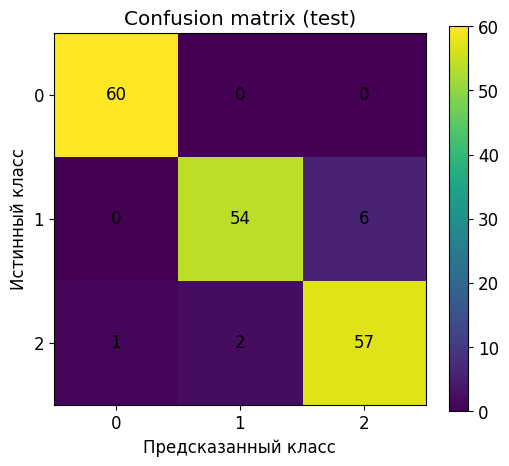

In [30]:
# Визуализация confusion matrix

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation="nearest")
ax.set_xlabel("Предсказанный класс")
ax.set_ylabel("Истинный класс")
ax.set_title("Confusion matrix (test)")
ax.set_xticks(np.arange(len(np.unique(y))))
ax.set_yticks(np.arange(len(np.unique(y))))
plt.colorbar(im, ax=ax)
# подписи внутри клеток
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=12)

plt.show()

### 3.3. Precision, Recall, F1 для многоклассового случая

Для каждого конкретного класса $k$ мы можем рассматривать «локальную» бинарную задачу:

- **Положительный класс**: класс $k$,
- **Отрицательный класс**: все остальные классы.

Тогда для класса $k$ можно определить:

- **True Positive (TP\_k)** — объектов класса $k$, предсказанных как $k$,
- **False Positive (FP\_k)** — объектов других классов, предсказанных как $k$,
- **False Negative (FN\_k)** — объектов класса $k$, предсказанных как другой класс.

На их основе вводятся:

- **Precision (точность)** для класса $k$:

$$
\text{Precision}_k = \frac{TP_k}{TP_k + FP_k}.
$$

Показывает: среди всех объектов, предсказанных как класс $k$, какая доля действительно относится к этому классу.

- **Recall (полнота)** для класса $k$:

$$
\text{Recall}_k = \frac{TP_k}{TP_k + FN_k}.
$$

Показывает: среди всех объектов истинного класса $k$, какую долю мы правильно нашли.

- **F1-score** для класса $k$ — гармоническое среднее precision и recall:

$$
\text{F1}_k = 2 \cdot \frac{\text{Precision}_k \cdot \text{Recall}_k}{\text{Precision}_k + \text{Recall}_k}.
$$

Эти величины считаются отдельно для каждого класса. Затем их нужно **как-то агрегировать** в одну метрику.

#### Способы усреднения (average):

1. `macro` — простое среднее по классам:
   - считаем F1\_k для каждого класса,
   - берём арифметическое среднее,
   - все классы имеют **равный вес**, независимо от их размера.

2. `weighted` — среднее по классам с весами, пропорциональными числу объектов:
   - классы с большим количеством объектов сильнее влияют на итог.

3. `micro` — суммарные TP, FP, FN по всем классам, затем считаются precision / recall / F1 из этих сумм:
   - эквивалентно рассмотрению **каждого объекта** как отдельного «микро-предсказания»,
   - хорошо отражает «общую» долю верных ответов в задачах с дисбалансом.


### 3.4. `classification_report` и разные варианты F1 в `sklearn`

`sklearn.metrics.classification_report` автоматически считает для каждого класса:

- precision,
- recall,
- F1-score,
- support (количество объектов данного класса в выборке).

Также он выводит:

- macro avg,
- weighted avg.

Отдельно можно считать F1 с разными `average`:

- `f1_score(y_true, y_pred, average="macro")`,
- `f1_score(y_true, y_pred, average="weighted")`,
- `f1_score(y_true, y_pred, average="micro")`.


In [9]:
# classification_report для тестовой выборки

print("Classification report (test):")
print(classification_report(y_test, y_test_pred))

Classification report (test):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.96      0.90      0.93        60
           2       0.90      0.95      0.93        60

    accuracy                           0.95       180
   macro avg       0.95      0.95      0.95       180
weighted avg       0.95      0.95      0.95       180



In [10]:
# Разные варианты F1

f1_macro = f1_score(y_test, y_test_pred, average="macro")
f1_weighted = f1_score(y_test, y_test_pred, average="weighted")
f1_micro = f1_score(y_test, y_test_pred, average="micro")

print(f"F1 (macro):    {f1_macro:.4f}")
print(f"F1 (weighted): {f1_weighted:.4f}")
print(f"F1 (micro):    {f1_micro:.4f}")

F1 (macro):    0.9499
F1 (weighted): 0.9499
F1 (micro):    0.9500


### 3.5. Небольшой ручной пример: считаем метрики для одного класса по confusion matrix

Пусть у нас есть confusion matrix для трёх классов (0, 1, 2):

- строка — истинный класс,
- столбец — предсказанный класс.

Для класса 0:

- $TP_0$ — элемент $(0, 0)$,
- $FP_0$ — сумма по столбцу 0, кроме $(0, 0)$,
- $FN_0$ — сумма по строке 0, кроме $(0, 0)$.

По ним можем вручную посчитать precision, recall и F1 для класса 0 и сравнить с тем, что даёт `classification_report`.


In [32]:
# Ручной пример расчёта метрик для класса 0

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix:")
print(cm)

# Для класса 0
TP_0 = cm[0, 0]
FP_0 = cm[:, 0].sum() - TP_0
FN_0 = cm[0, :].sum() - TP_0

precision_0 = TP_0 / (TP_0 + FP_0) if (TP_0 + FP_0) > 0 else 0.0
recall_0 = TP_0 / (TP_0 + FN_0) if (TP_0 + FN_0) > 0 else 0.0
if precision_0 + recall_0 > 0:
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0)
else:
    f1_0 = 0.0

print(f"Для класса 0: TP={TP_0}, FP={FP_0}, FN={FN_0}")
print(f"Precision_0: {precision_0:.4f}")
print(f"Recall_0:    {recall_0:.4f}")
print(f"F1_0:        {f1_0:.4f}")
print()
print(classification_report(y_test, y_test_pred))

Confusion matrix:
[[60  0  0]
 [ 0 54  6]
 [ 1  2 57]]
Для класса 0: TP=60, FP=1, FN=0
Precision_0: 0.9836
Recall_0:    1.0000
F1_0:        0.9917

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.96      0.90      0.93        60
           2       0.90      0.95      0.93        60

    accuracy                           0.95       180
   macro avg       0.95      0.95      0.95       180
weighted avg       0.95      0.95      0.95       180



## 4. Анализ предсказанных вероятностей

Логистическая регрессия в режиме `multinomial` возвращает **оценки вероятностей классов** (по softmax).  
Можно посмотреть на них через метод `predict_proba`.

Это полезно для:

- понимания уверенности модели в предсказаниях,
- анализа ошибок (модель уверенно ошиблась или «сомневалась»),
- последующей настройки порогов (в нерегламентированных задачах).


In [12]:
# Пример предсказанных вероятностей для нескольких объектов теста

proba_test = logreg_clf.predict_proba(X_test)

idx_sample = np.random.choice(len(X_test), size=5, replace=False)

for idx in idx_sample:
    x_point = X_test[idx]
    true_label = y_test[idx]
    pred_label = y_test_pred[idx]
    proba = proba_test[idx]

    print(f"Объект #{idx}: x = {x_point}, истинный класс = {true_label}, предсказанный класс = {pred_label}")
    print("Предсказанные вероятности классов:", proba)
    print("-")

Объект #128: x = [ 2.25922411 -0.16459537], истинный класс = 1, предсказанный класс = 1
Предсказанные вероятности классов: [6.68315145e-05 9.96969157e-01 2.96401149e-03]
-
Объект #165: x = [0.10636223 2.2580664 ], истинный класс = 2, предсказанный класс = 2
Предсказанные вероятности классов: [0.00508703 0.01322639 0.98168659]
-
Объект #134: x = [1.06119742 2.60119756], истинный класс = 2, предсказанный класс = 2
Предсказанные вероятности классов: [2.91698022e-04 5.02636111e-02 9.49444691e-01]
-
Объект #142: x = [-2.53678785  0.10634447], истинный класс = 0, предсказанный класс = 0
Предсказанные вероятности классов: [9.95939589e-01 1.74027603e-05 4.04300798e-03]
-
Объект #81: x = [2.02002412 0.52104077], истинный класс = 1, предсказанный класс = 1
Предсказанные вероятности классов: [1.54416685e-04 9.77447009e-01 2.23985746e-02]
-


## 5. Полиномиальные признаки и их влияние на решение

До сих пор мы работали с **линейной моделью** в исходных признаках $(x_1, x_2)$:

- логистическая регрессия в исходном пространстве задаёт **линейные границы** между классами в этом пространстве.

Чтобы получить **нелинейные границы**, можно:

- явно добавить **полиномиальные признаки**: $x_1^2, x_2^2, x_1 x_2, x_1^3, \dots$,
- обучить **линейную модель** в этом расширенном пространстве.

Это реализуется с помощью `PolynomialFeatures`:

- `degree=2` добавляет квадратичные признаки,
- `degree=3` — вплоть до кубических и т.д.

Таким образом мы получаем **нелинейные решающие границы** в исходном пространстве $(x_1, x_2)$, но модель по-прежнему остаётся линейной по параметрам.


### 5.1. Пайплайн: полиномиальные признаки + стандартизация + логистическая регрессия

Соберём новый пайплайн:

1. `PolynomialFeatures(degree=2, include_bias=False)`,
2. `StandardScaler` (стандартизация уже в полиномиальном пространстве),
3. `LogisticRegression(multi_class="multinomial", solver="lbfgs")`.

Посмотрим, как изменятся:

- accuracy на train / test,
- решающие области.


In [36]:
from sklearn.kernel_approximation import RBFSampler

# Пайплайн с полиномиальными признаками

DEGREE = 4
poly2_logreg_clf = Pipeline([
    ("poly", PolynomialFeatures(degree=DEGREE, include_bias=False)),
    # ("rbf", RBFSampler(gamma=1.0, n_components=300)),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

poly2_logreg_clf.fit(X_train, y_train)

y_train_pred_poly2 = poly2_logreg_clf.predict(X_train)
y_test_pred_poly2 = poly2_logreg_clf.predict(X_test)

acc_train_poly2 = accuracy_score(y_train, y_train_pred_poly2)
acc_test_poly2 = accuracy_score(y_test, y_test_pred_poly2)

print(f"Polynomial degree={DEGREE}:")
print(f"Accuracy (train): {acc_train_poly2:.4f}")
print(f"Accuracy (test):  {acc_test_poly2:.4f}")

Polynomial degree=4:
Accuracy (train): 0.9548
Accuracy (test):  0.9500


### 5.2. Визуализация решающих областей для модели с полиномиальными признаками

Сравним решающие области:

- для линейной модели,
- для модели с полиномиальными признаками степени 2.

Ожидаем, что границы станут более «изгибающимися» и лучше подстроятся под данные, но при этом возрастёт риск переобучения.


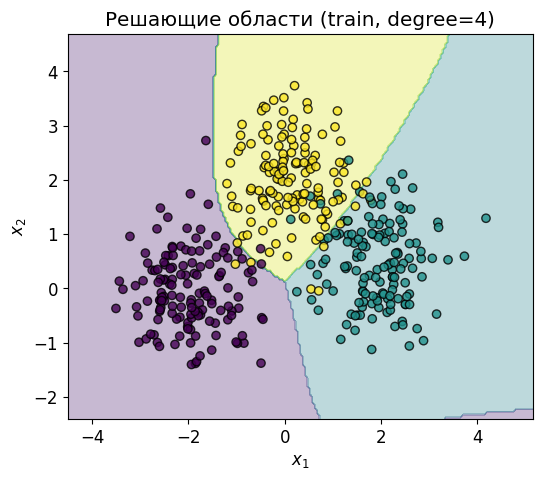

In [37]:
plot_decision_regions(poly2_logreg_clf, X_train, y_train, title=f"Решающие области (train, degree={DEGREE})")

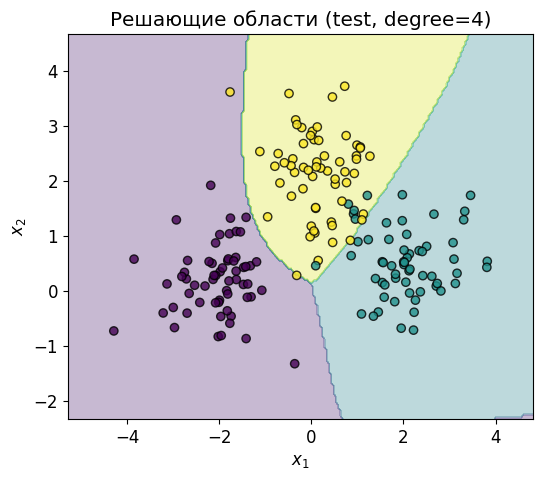

In [38]:
plot_decision_regions(poly2_logreg_clf, X_test, y_test, title=f"Решающие области (test, degree={DEGREE})")

### 5.3. Сравнение метрик: линейная vs полиномиальная модель

Сравним основные метрики (accuracy и F1) для:

- линейной логистической регрессии,
- логистической регрессии с полиномиальными признаками степени 2.

Это поможет оценить, даёт ли усложнение модели реальный выигрыш, и нет ли признаков переобучения (например, сильно вырос accuracy на train, но ухудшился на test).


In [24]:
# Линейная модель (для сравнения уже всё посчитано)
print("=== Линейная multinomial логрег ===")
print(f"Accuracy (train): {acc_train:.4f}")
print(f"Accuracy (test):  {acc_test:.4f}")
print(f"F1_macro (test):  {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print()

# Модель с полиномиальными признаками
print(f"=== Multinomial логрег с PolynomialFeatures degree={DEGREE} ===")
print(f"Accuracy (train): {acc_train_poly2:.4f}")
print(f"Accuracy (test):  {acc_test_poly2:.4f}")
print(f"F1_macro (test):  {f1_score(y_test, y_test_pred_poly2, average='macro'):.4f}")

=== Линейная multinomial логрег ===
Accuracy (train): 0.9524
Accuracy (test):  0.9500
F1_macro (test):  0.9499

=== Multinomial логрег с PolynomialFeatures degree=4 ===
Accuracy (train): 0.9548
Accuracy (test):  0.9500
F1_macro (test):  0.9499


## 6. Итоговые выводы

В этом ноутбуке мы:

1. Сгенерировали синтетический двумерный датасет с тремя классами и разделили его на train / test.
2. Построили пайплайн `StandardScaler + LogisticRegression(multi_class="multinomial")` и обучили многоклассовую логистическую регрессию (softmax-регрессию).
3. Визуализировали решающие области для обученной модели и увидели, как она разделяет пространство $(x_1, x_2)$.
4. Подробно рассмотрели метрики многоклассовой классификации:
   - `accuracy`,
   - confusion matrix,
   - precision, recall, F1 для каждого класса,
   - способы усреднения F1: macro / micro / weighted,
   - `classification_report`.
5. Ручным примером показали, как считать precision / recall / F1 для одного класса по confusion matrix.
6. Проанализировали предсказанные вероятности через `predict_proba`.
7. Добавили полиномиальные признаки (degree=2) через `PolynomialFeatures` и построили новую модель:
   - сравнили accuracy и F1 на train / test,
   - сравнили решающие области с линейной моделью,
   - обсудили влияние усложнения модели на качество и риск переобучения.

Дальнейшие возможные расширения:

- использовать полиномиальные признаки более высоких степеней и/или регуляризацию (параметр `C` в `LogisticRegression`),
- попробовать другие модели (`RandomForestClassifier`, `SVC`, `XGBoost`) и сравнить их по метрикам,
- рассмотреть многолейбловые задачи (multi-label) с независимыми сигмоидами и многомерной BCE.
